# Table of Contents

[Task](#task)

1. [Task 1. A/B Testing](#task_1)
   
    1.1 [Data Import](#data_import)
   
    1.2 [Exploratory Data Analysis](#first_look)
   
    1.3 [A/B Test](#ab_test)
   
      1.3.1 [Data Preparation and Conversion Analysis](#conversion)
       
      1.3.2 [A/B Test Results for Conversion](#conversion_results)
       
      1.3.3 [Data Preparation and ARPPU Analysis](#arppu)
       
    * [Checking for Normal Distribution using Graphs](#normal_graph)
           
    * [Checking for Normal Distribution using Shapiro-Wilk Test](#normal_shapiro)
          
    * [Comparing Groups using t-test](#t_test)
         
    * [Comparing Groups using Mann-Whitney](#mann-whitney)
           
    * [Comparing Groups using Bootstrap](#bootstrap)
           
    * [Bootstrap for Mean Value](#bootstrap_mean)
           
    1.3.4 [A/B Test Results](#ab_test_results)
       
2. [Task 2. SQL](#task_2)

   2.1 [Counting Active Students](#task_2_1)
   
    * [Answer](#answer_2_1)
       
   2.2 [Optimizing the Funnel](#task_2_2)
   
    * [Answer](#answer_2_2)
       
3. [Task 3. Python](#task_3)


# Karpov Courses final project
   
## Task 1. A/B Testing <a class="anchor" id="task"></a>

**1.1 Description**

One of the main tasks of an analyst in our team is to conduct experiments correctly. To do this, we use the A/B testing method. During the testing of one hypothesis, a new payment mechanism for services on the website was proposed to the target group, while the control group retained the basic mechanism. As a task, you need to analyze the results of the experiment and make a conclusion whether to launch the new payment mechanism for all users.

**1.2 Input Data**

As input data, you have 4 csv-files:

-   [**groups.csv**](https://disk.yandex.ru/d/58Us0DWOzuWAjg) - a file with information about the user's belonging to the control or experimental group (A - control, B - target group) 
-   [**groups_add.csv**](https://disk.yandex.ru/d/3aARY-P9pfaksg) - an additional file with users that was sent to you 2 days after the data was provided
-   [**active_studs.csv**](https://disk.yandex.ru/d/prbgU-rZpiXVYg) - a file with information about the users who logged into the platform during the days of the experiment. 
-   [**checks.csv**](https://disk.yandex.ru/d/84hTmELphW2sqQ) - a file with information about user payments during the days of the experiment. 

**1.3 Questions**

We suggest that you answer the following questions:

-   What metrics do you look at during analysis and why?
-   Are there any differences in the indicators and what can they be related to?
-   Are these differences statistically significant?
-   Should the new mechanism be launched for all users?

This list of questions is not mandatory, and you can rely on your own plan in your answer.

**1.4 Requirements for the Answer**

-   When performing the test task, it is necessary to use the Python programming language. 
-   The file must have comments on the actions that you perform with the data. 
-   The file should be a complete report with conclusions made during the research.

## Task 2. SQL 

**2.1 Very diligent students.**

**2.1.1 Condition**

Educational courses consist of various lessons, each of which consists of several small tasks. Each such small task is called a "pea".

Let's call a very diligent student a user who has correctly solved 20 peas at least once this month.

**2.1.2 Task**

Given the default.peas table:

| Attribute name | Attribute type | Semantic value                           |
|----------------|----------------|------------------------------------------|
| st_id          | int            | Student ID                               |
| timest         | timestamp      | Time of solving the task                 |
| correct        | bool           | Whether the pea was solved correctly     |
| subject        | text           | Discipline in which the pea is located   |

You need to write an **optimal query** that will provide information about the number of very diligent students.
  
NB! By a diligent student we mean a student who has correctly solved 20 tasks this month.  

**2.2 Funnel optimization**

**2.2.1 Condition**

The educational platform offers students courses using the trial model: a student can solve only 30 peas for free per day. To get unlimited tasks in a particular discipline, a student must purchase full access. The team conducted an experiment where a new payment screen was tested.

**2.2.2 Task**

Given the default.peas and default.studs tables:

| Attribute name | Attribute type | Semantic value                          |
|----------------|----------------|-----------------------------------------|
| st_id          | int            | Student ID                               |
| test_grp       | text           | Label of the student in this experiment |

and default.final_project_check:

| Attribute name | Attribute type | Semantic value                                |
|----------------|----------------|-----------------------------------------------|
| st_id          | int            | Student ID                                    |
| sale_time      | timestamp      | Purchase time                                 |
| money          | int            | The price at which this course was purchased  |
| subject        | text           | Discipline for which full access was purchased|

You need to provide the following information about user groups in one query:

-   ARPU
-   ARPAU
-   Purchase conversion rate
-   Conversion rate of an active user to purchase
-   Conversion rate of a user who is active in mathematics (subject = 'math') to purchase a mathematics course

ARPU is calculated relative to all users who have been grouped.

A user is considered **active** if they have correctly solved **more than** 10 tasks in any discipline over their entire history.

A user is considered **active in mathematics** if they have correctly solved **2 or more** tasks in mathematics over their entire history.

**All data is in tabular form in Clickhouse**

## Task 3. Python

**3.1 Task**

1. Implement a function that will automatically load information from the additional file `groups_add.csv` (headers may differ) and recalculate metrics based on additional parameters.
2. Implement a function that will plot graphs based on the obtained metrics.


___

In [3]:
from scipy.stats import chi2_contingency
import pandahouse as ph
from scipy.stats import norm
import scipy.stats as ss
import numpy as np
import pandas as pd
import requests
import urllib.parse
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

%matplotlib inline
plt.style.use('default')

c:\Users\yasno\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1 <a class="anchor" id="task_1"></a>


## 1.1 Data import <a class="anchor" id="data_import"></a>


In [1]:
# Importing data from Yandex.Disk into DataFrame groups
try:
    targetUrl = "https://disk.yandex.ru/d/58Us0DWOzuWAjg"
    url = "https://cloud-api.yandex.net/v1/disk/public/resources?public_key=" + \
        urllib.parse.quote(targetUrl, safe="")
    responseData = requests.get(url)
    url = responseData.json()['file'] + '/' + responseData.json()['name']
    url = str(url.encode('cp1251'))[2:]
    num = len(url)
    url = url[:num-1]
    groups = pd.read_csv(url, sep=';')
except:
    print("Yandex returns an error. It is necessary to uncomment the line below and import data from the disk manually.")

Yandex returns an error. It is necessary to uncomment the line below and import data from the disk manually.


In [5]:
# Importing data from Yandex.Disk into DataFrame groups_add
try:
    targetUrl = "https://disk.yandex.ru/d/3aARY-P9pfaksg"
    url = "https://cloud-api.yandex.net/v1/disk/public/resources?public_key=" + \
        urllib.parse.quote(targetUrl, safe="")
    responseData = requests.get(url)
    url = responseData.json()['file'] + '/' + responseData.json()['name']
    url = str(url.encode('cp1251'))[2:]
    num = len(url)
    url = url[:num-1]
    groups_add = pd.read_csv(url)
except:
    print("Yandex returns an error. It is necessary to uncomment the line below and import data from the disk manually.")

In [ ]:
# Importing data from Yandex.Disk into DataFramee active_studs
try:
    targetUrl = "https://disk.yandex.ru/d/prbgU-rZpiXVYg"
    url = "https://cloud-api.yandex.net/v1/disk/public/resources?public_key=" + \
        urllib.parse.quote(targetUrl, safe="")
    responseData = requests.get(url)
    url = responseData.json()['file'] + '/' + responseData.json()['name']
    url = str(url.encode('cp1251'))[2:]
    num = len(url)
    url = url[:num-1]
    active_studs = pd.read_csv(url, sep=';')
except:
    print("Yandex returns an error. It is necessary to uncomment the line below and import data from the disk manually.")

In [ ]:
# Importing data from Yandex.Disk into DataFrame checks
try:
    targetUrl = "https://disk.yandex.ru/d/84hTmELphW2sqQ"
    url = "https://cloud-api.yandex.net/v1/disk/public/resources?public_key=" + \
        urllib.parse.quote(targetUrl, safe="")
    responseData = requests.get(url)
    url = responseData.json()['file'] + '/' + responseData.json()['name']
    url = str(url.encode('cp1251'))[2:]
    num = len(url)
    url = url[:num-1]
    checks = pd.read_csv(url, sep=';')
except:
    print("Yandex returns an error. It is necessary to uncomment the line below and import data from the disk manually.")

# 1.2 Exploratory Data Analysis <a class="anchor" id="first_look"></a>

In [ ]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
groups.shape

(74484, 2)

In [ ]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [ ]:
groups_add.shape

(92, 2)

In [ ]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [ ]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [ ]:
active_studs.shape

(8341, 1)

In [ ]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [ ]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [ ]:
checks.shape

(541, 2)

In [ ]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


## 1.3 A/B test<a class="anchor" id="ab_test"></a>

To properly process the results of an A/B test, it is necessary to answer some questions.

### What metrics are we looking at during the analysis and why?

We have data on user payments for the test period and data on site visits. Thus, we can calculate three metrics:

- user conversion to purchase;
- ARPU (Average Revenue Per User) - average revenue from all customers;
- ARPPU (Average Revenue Per Paying User) - average revenue from paying customers.

However, in the end, we will only calculate two metrics: conversion and ARPPU. Because the conversion did not change significantly, and ARPU and ARPPU are proportional to each other through conversion.

### Are there any differences in the indicators and what can they be associated with?

There are differences in the indicators, and they can be caused by several reasons, but we assume that the data is correct and indicative. Thus, we will consider the difference in the data as a result of the test.

### Are these differences statistically significant?

There is no statistically significant difference in the conversion calculations.
There is a statistically significant difference in ARPPU.
Also, there is a difference when looking at data by quantiles. Details in the test results - [A/B test results](#ab_test_results)

### Should we launch the new mechanism for all users?

First, it is necessary to check the data on splitting, if everything is correct, and the system is splitting correctly, then you can launch the new mechanism. However, it is worth looking at users who are below the 20th percentile. For them, the average check decreased, which negatively affects profits. If there is any regularity among them, then it is worth identifying it and not launching the new mechanism for these users.

**In general, the new mechanism is recommended for launch, as there is a statistically significant increase in the average check.**


### 1.3.1 Data preparation and conversion analysis<a class="anchor" id="conversion"></a> 

Let's combine the data frames based on the test data.

In [ ]:
full_groups = groups.append(groups_add)

In [ ]:
full_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [ ]:
full_groups.shape

(74576, 2)

In [ ]:
full_groups.id.nunique()

74576

Based on the sum of unique IDs, we can see that there were no duplicates in groups and groups_add.
___
Let's take a look at the number of users in the control and target groups.

<AxesSubplot:xlabel='grp', ylabel='count'>

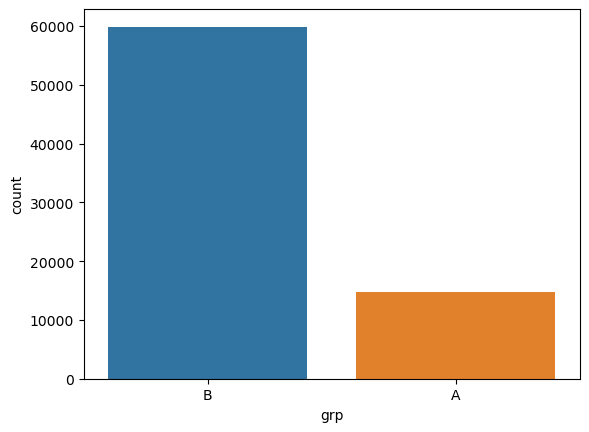

In [ ]:
sns.countplot(x=full_groups["grp"])

We will merge the tables full_group and active_studs, and then with the checks table. This is done to obtain real data, since there are students who did not log in to the platform but paid for the trial period, i.e. they show revenue, but did not participate in the test because they did not log in to the platform and did not see the changes.

In [ ]:
full_groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [ ]:
full_groups_active = full_groups.merge(active_studs, how='inner', left_on='id', right_on='student_id')

In this dataframe *full_groups_active*, there are users who:

* participated in the test
* visited the site during the test.

In [ ]:
full_groups_active

,id,grp,student_id
0,1627,A,1627
1,2085,B,2085
2,2215,B,2215
3,3391,A,3391
4,3401,B,3401
...,...,...,...
8336,5760471,B,5760471
8337,5777081,B,5777081
8338,5870856,A,5870856
8339,5945085,B,5945085


In [ ]:
full_groups_active_rev = full_groups_active.merge(checks, how='left', on='student_id')

In this dataframe *full_groups_active_rev*, there are users who:

* participated in the test  
* visited the site during the test  
* made payment on the site, i.e. saw either the old or the new payment mechanism on the site.

In [ ]:
full_groups_active_rev

,id,grp,student_id,rev
0,1627,A,1627,990.0
1,2085,B,2085,NaN
2,2215,B,2215,NaN
3,3391,A,3391,NaN
4,3401,B,3401,NaN
...,...,...,...,...
8336,5760471,B,5760471,NaN
8337,5777081,B,5777081,NaN
8338,5870856,A,5870856,NaN
8339,5945085,B,5945085,NaN


remove the redundand column

In [ ]:
full_groups_active_rev = full_groups_active_rev.drop(columns = 'student_id')

Add a column that will show whether the student converted to payment.

In [ ]:
full_groups_active_rev['is_converted'] = ~full_groups_active_rev.rev.isna()

In [ ]:
full_groups_active_rev.head()

,id,grp,rev,is_converted
0,1627,A,990.0,True
1,2085,B,NaN,False
2,2215,B,NaN,False
3,3391,A,NaN,False
4,3401,B,NaN,False


<AxesSubplot:xlabel='grp', ylabel='count'>

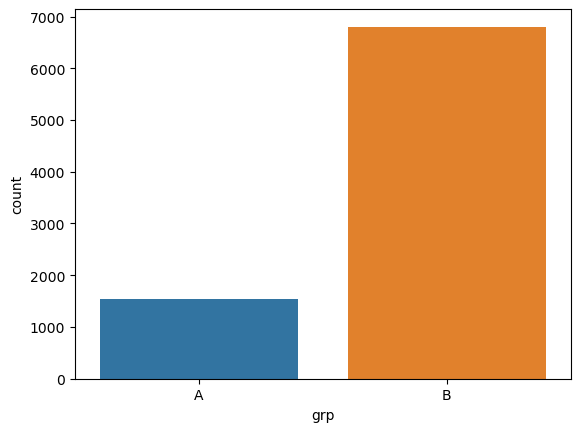

In [ ]:
sns.countplot(x=full_groups_active_rev["grp"])

As seen from the plot, group B has more users than group A. This raises suspicions about incorrect splitting, however, we do not have enough information to make any clear conclusion. Therefore, we assume that the data is real and correct.
___

Calculate the conversion for both groups

In [ ]:
conversion = full_groups_active_rev\
                            .query("grp == 'A' & is_converted == True")\
                            .groupby('grp',)\
                            .agg({'id':'count'})\
                            / full_groups_active_rev[full_groups_active_rev.grp == 'A'].id.count() * 100

conversion = conversion.append(full_groups_active_rev\
                            .query("grp == 'B' & is_converted == True")\
                            .groupby('grp')\
                            .agg({'id':'count'})\
                            / full_groups_active_rev[full_groups_active_rev.grp == 'B'].id.count() * 100
                                  )
conversion = conversion.reset_index().rename(columns={'id':'conversion'})

In [ ]:
conversion

,grp,conversion
0,A,5.071521
1,B,4.615611


"Conversion in group B decreased by 0.46 percentage points (a decrease of 8.99% in group B compared to group A). 
___
It is necessary to determine whether this decrease in conversion is statistically significant."

In [ ]:
pd.crosstab(full_groups_active_rev.is_converted, full_groups_active_rev.grp)

grp,A,B
is_converted,,
False,1460,6489
True,78,314


In [ ]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(full_groups_active_rev.is_converted, full_groups_active_rev.grp))

In [ ]:
stat, p

(0.48480826522557896, 0.48625240457231045)

### 1.3.2 A/B test results for conversion rate <a class="anchor" id="conversion_results"></a> 

As the p-value is significantly higher than 0.05, we have no grounds to reject the null hypothesis.

In other words, **the decrease in conversion rate is not statistically significant.**
___

### 1.3.3 Data Preparation and ARPPU Analysis <a class="anchor" id="arppu"></a>

In [ ]:
full_groups_active_rev.groupby('grp',as_index=False).agg({'rev':'mean'})

,grp,rev
0,A,933.589744
1,B,1257.878992


In [ ]:
full_groups_active_rev.groupby('grp',as_index=False).agg({'rev':'median'})

,grp,rev
0,A,585.0
1,B,1140.0


"Average revenue in group B increased by 324.3, which represents a growth of 34.7%. 
___
It is necessary to determine whether this increase in average revenue is statistically significant."

#### Checking for normality using diagrams <a class="anchor" id="normal_graph"></a>

In [ ]:
df_grp_A = full_groups_active_rev.query("grp == 'A' and is_converted == True")
df_grp_B = full_groups_active_rev.query("grp == 'B' and is_converted == True")

<AxesSubplot:xlabel='grp', ylabel='rev'>

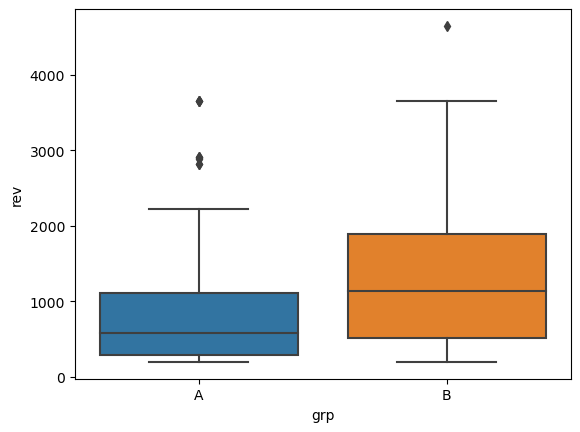

In [ ]:
#data=work_df.query("rev > 0"), y="rev", x="grp"
sns.boxplot(data=full_groups_active_rev, y='rev', x='grp')

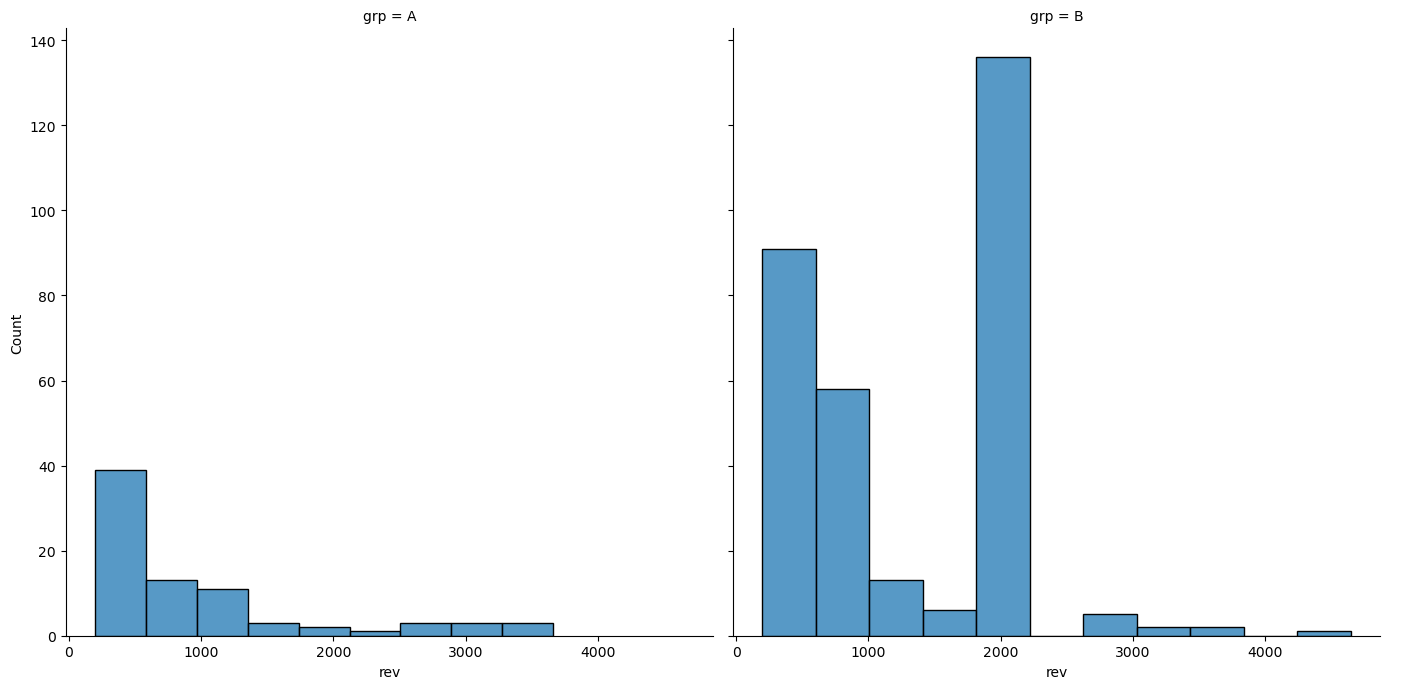

In [ ]:
data = full_groups_active_rev[["grp", "rev"]]
g = sns.FacetGrid(data, col="grp", height=7)
g.map(sns.histplot, "rev")
g.add_legend();

It can be seen that the data is not normally distributed.
The graphs show that the 'rev' variable has a non-normal distribution and a large number of outliers.

#### Checking for Normal Distribution using Shapiro-Wilk Test <a class="anchor" id="normal_shapiro"></a>


In [ ]:
shapiro_test = ss.shapiro(df_grp_A.rev)
shapiro_test

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [ ]:
shapiro_test = ss.shapiro(df_grp_B.rev)
shapiro_test

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

**Conclusion**  
Since the p-value is significantly less than 0.05, we reject the null hypothesis. In other words, **the data on revenue is not normally distributed.**

#### Comparing Groups using t-test <a class="anchor" id="t_test"></a>

The t-test can be used for groups with a non-normal distribution. The homogeneity of variance is a more important criterion for the t-test. We will check the homogeneity of variance using the Levene's test.

In [ ]:
ss.levene(df_grp_A.rev, df_grp_B.rev, center='median')

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

In the Levene test, the null hypothesis is that all data have equal variances. Since the p-value is greater than 0.05, we have no grounds to reject the null hypothesis.   
Therefore, our **both samples have equal variances and we can conduct t-test.**   
Note: for the Levene test, we use the 'median' parameter for non-normal distributions. ([link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html))


In [ ]:
ss.ttest_ind(df_grp_A.rev, df_grp_B.rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

#### Comparing Groups using Mann-Whitney <a class="anchor" id="mann-whitney"></a>


In [ ]:
ss.mannwhitneyu(df_grp_A.rev, df_grp_B.rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

The null hypothesis for the Mann-Whitney test is that two samples belong to the same population. 
___
Since the p-value is less than 0.05, we can reject the null hypothesis and conclude that there is a statistically significant difference between the samples. In other words, there is a statistically significant difference in the distribution of ranks between these two samples (groups A and B).

#### Comparing Groups using Bootstrap <a class="anchor" id="bootstrap"></a>


create a function, which will calculate bootstrap

In [ ]:
def get_bootstrap(
    data_column_1, # numerical values of the first sample
    data_column_2, # numerical values of the second sample
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, # the statistic of interest
    bootstrap_conf_level = 0.95, # significance level
    quantile = 0.5,        # quantile, if using bootstrap for quantiles, defaults to 0.5
    show_diagram = True
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # extract subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # parameter for returning data
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # to maintain variance, we take the same sample size
            replace = True
        ).values
        
        if statistic == np.quantile:
            boot_data.append(statistic(samples_1-samples_2, quantile))
        else:
            boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    if show_diagram == True:
        # Visualization
        _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
        for bar in bars:
            if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.style.use('ggplot')
        plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
    else:
        pass
       
    return {"quants": quants, 
            "p_value": p_value}

#### Bootstrap for mean value <a class="anchor" id="bootstrap_mean"></a>


  0%|          | 0/1000 [00:00<?, ?it/s]

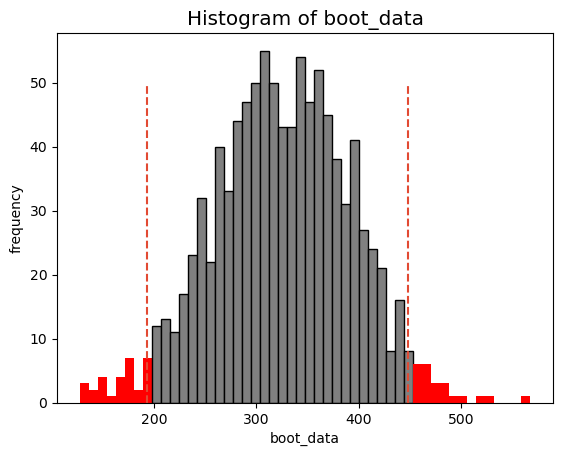

{'quants':                 0
 0.025  193.451839
 0.975  448.185522,
 'p_value': 1.211858474858098e-06}

In [ ]:
get_bootstrap(
    df_grp_B.rev, # numerical values of the first sample
    df_grp_A.rev, # numerical values of the second sample
    boot_it = 1000, # number of bootstrap sub-samples
    statistic = np.mean, # the statistic of interest
    bootstrap_conf_level = 0.95 # significance level
)

## 1.3.4 A/B test results <a class="anchor" id="ab_test_results"></a>


* The t-test indicates a statistically significant difference in ARPPU between the groups.   
* The Mann-Whitney test also shows that there is a statistically significant difference in ranks between the samples.   
* Bootstrap analysis indicates a statistically significant increase in ARPPU for Group B. The range of ARPPU increase is between 196.9 to 462.3.

___

# Task 2. SQL <a class="anchor" id="task_2"></a>

## Task 2.1 Counting Active Students<a class="anchor" id="task_2_1"></a>


In [ ]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
'database':'default',
'user':'student',
'password':'dpo_python_2020'
}

In [ ]:
connection_test = dict(database='test',
host='http://clickhouse.beslan.pro:8080',
user='student-rw',
password='656e2b0c9c')

Since the database contains data only for October 30 and 31, 2021, it is not possible to filter the data for the current month.  
However, below is the code in which you can change the date. To get data for the current month, you need to assign the value `toStartOfMonth(today())` to the variable `reporting_month`.

In [ ]:
reporting_month = '\'2021-10-01\''               
#reporting_month = 'toStartOfMonth(today())'   # Uncomment if you need to get data for the current month.

q = f'''
SELECT COUNT(st_id) AS active_stud_count
FROM
    (
    SELECT
        st_id
        , SUM(correct) AS peas_num
        , toStartOfMonth(timest) AS curr_month
    FROM default.peas
    WHERE curr_month = {reporting_month}
    GROUP BY st_id, curr_month
    HAVING peas_num >= 20
    )
'''
# sending the request and saving data to a pandas DataFrame
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

#### Answer <a class="anchor" id="answer_2_1"></a>

In [ ]:
q_test.active_stud_count[0]

136

## Optimizing the Funnel<a class="anchor" id="task_2_2"></a>

___
All metrics are calculated in the query below  
CRAU - Conversion Rate of Active User to purchase  
CRMAU - Conversion Rate of Math Active User (subject = 'math') to purchase of Math course 

In [ ]:
q = '''
-- default.studs AS t1
-- default.peas AS t2
-- default.final_project_check AS t3
-- active_users AS t4
-- money_total AS t5

WITH active_users AS 
    (
    -- A subquery that creates two columns 'active' and 'active_math'
    -- with a value of 1 or 0 depending on the condition of activity and
    -- math activity.
    SELECT
        t2.st_id AS st_id,
        SUM(t2.correct) > 10 AS active,
        sumIf(t2.correct, t2.subject = 'Math') >= 2 AS active_math
    FROM 
        default.peas AS t2
    GROUP BY
        t2.st_id
    ),
    
    money_total AS
    (
    -- A subquery that creates a table indicating the revenue from each user.
    SELECT
        t3.st_id AS st_id,
        sum(t3.money) AS rev
    FROM
      default.final_project_check AS t3
    GROUP BY
      t3.st_id
    )
    
SELECT 
    t1.test_grp AS test_group,
    SUM (t5.rev) / COUNT (t1.st_id) AS ARPU,
    sumIf(t5.rev, t4.active = 1) / countIf(t4.st_id, t4.active = 1) AS ARPAU,
    countIf(t1.st_id, t5.rev > 0) / COUNT(t1.st_id) * 100 AS CR,
    countIf(t1.st_id, (t4.active AND t5.rev > 0)) / countIf(t1.st_id, t4.active) * 100 AS CRAU,
    countIf(t1.st_id, (t4.active_math AND t5.rev > 0)) / countIf(t1.st_id, t4.active_math) * 100 AS CRMAU

FROM
    default.studs AS t1
        LEFT JOIN active_users AS t4 ON t1.st_id = t4.st_id
        LEFT JOIN money_total AS t5 ON t1.st_id = t5.st_id
GROUP BY test_group
'''
# sending the request and saving data to a pandas DataFrame
q_test = ph.read_clickhouse(query=q, connection=connection_default)

#### Answer <a class="anchor" id="answer_2_2"></a>

In [ ]:
q_test

,test_group,ARPU,ARPAU,CR,CRAU,CRMAU
0,control,4540.983607,10393.700787,4.918033,11.023622,10.204082
1,pilot,11508.474576,29739.583333,10.847458,26.041667,14.285714


# Task 3. Python <a class="anchor" id="task_3"></a>

___

We assume that the input to the function will be the same data as for Task 1:
- main_file - [**groups.csv**](https://disk.yandex.ru/d/58Us0DWOzuWAjg) - a file with information about user membership in the control or experimental group (A - control, B - target group).
- add_file - [**groups_add.csv**](https://disk.yandex.ru/d/3aARY-P9pfaksg) - an additional file with users that was sent to you 2 days after the data was transferred.
- active_studs - [**active_studs.csv**](https://disk.yandex.ru/d/prbgU-rZpiXVYg) - a file with information about users who logged into the platform on the days of the experiment.
- checks - [**checks.csv**](https://disk.yandex.ru/d/84hTmELphW2sqQ) - a file with information about user payments on the days of the experiment.


In [ ]:
# The function loads information from the additional file and recalculates metrics based on additional parameters.
def get_metrics(main_file, add_file, active_studs, checks):
    '''
    The function takes 4 data frames as input, as in task 1:
    main_file - a data frame with information about user belonging to the control or experimental group (A - control, B - target group)
    add_file - additional data frame with users
    active_studs - a data frame with information about users who logged into the platform during the experiment.
    checks - a data frame with information about user payments during the experiment.

    The function outputs 4 data frames with metric calculations by group:
    user_groups - the number of users by group
    conversion - conversion rate calculation
    arppu - calculation of the average check for paying users
    median - calculation of the median check for paying users
    '''
    # importing required modules
    import pandas as pd
    
    full_groups = main_file.append(add_file)
    full_groups_active = full_groups.merge(active_studs, how='inner', left_on='id', right_on='student_id')
    full_groups_active_rev = full_groups_active.merge(checks, how='left', on='student_id')
    # removing redundant column
    full_groups_active_rev = full_groups_active_rev.drop(columns = 'student_id')
    #adding a column that will show whether the student converted to payment or not.
    full_groups_active_rev['is_converted'] = ~full_groups_active_rev.rev.isna()
        
    # calculating the conversion for both groups
    conversion = full_groups_active_rev\
                            .query("grp == 'A' & is_converted == True")\
                            .groupby('grp',)\
                            .agg({'id':'count'})\
                            / full_groups_active_rev[full_groups_active_rev.grp == 'A'].id.count() * 100

    conversion = conversion.append(full_groups_active_rev\
                            .query("grp == 'B' & is_converted == True")\
                            .groupby('grp')\
                            .agg({'id':'count'})\
                            / full_groups_active_rev[full_groups_active_rev.grp == 'B'].id.count() * 100
                                  )
    conversion = conversion.reset_index().rename(columns={'id':'conversion'})
    # calculating ARPPU
    arppu = full_groups_active_rev.groupby('grp',as_index=False).agg({'rev':'mean'})
    arppu = arppu.rename(columns={'rev':'arppu'})
    # calculating median for PPU
    median = full_groups_active_rev.groupby('grp',as_index=False).agg({'rev':'median'})
    median = median.rename(columns={'rev':'median'})
    user_groups =  full_groups_active_rev\
                .groupby('grp', as_index=False)\
                .agg({'id':'count'})
    return user_groups, conversion, arppu, median    

checking function works

In [ ]:
user_groups, conversion, arppu, median = get_metrics(groups, groups_add, active_studs, checks)

In [ ]:
user_groups

,grp,id
0,A,1538
1,B,6803


In [ ]:
conversion

,grp,conversion
0,A,5.071521
1,B,4.615611


In [ ]:
arppu

,grp,arppu
0,A,933.589744
1,B,1257.878992


In [ ]:
median

,grp,median
0,A,585.0
1,B,1140.0


**The function works**

In [ ]:
# Function that plots charts for metrics.
def plot_metrics(user_groups, conversion, arppu, median):
    '''
    The function receives 4 dataframes as inputs:

    user_groups - the number of users in each group
    conversion - conversion rate calculation
    arppu - average check calculation for paying users
    median - median check calculation for paying users
    and plots graphs based on them.
    '''
    # importing required modules
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    %matplotlib inline
    import numpy as np
    
    
    #sns.set(rc={'figure.figsize':(20,12)})
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    sns.barplot(ax=axes[0, 0], data=user_groups, x="grp", y="id")
    sns.barplot(ax=axes[0, 1], data=conversion, x="grp", y="conversion")
    sns.barplot(ax=axes[1, 0], data=arppu, x="grp", y="arppu")
    sns.barplot(ax=axes[1, 1], data=median, x="grp", y="median")
    
   

checking function works

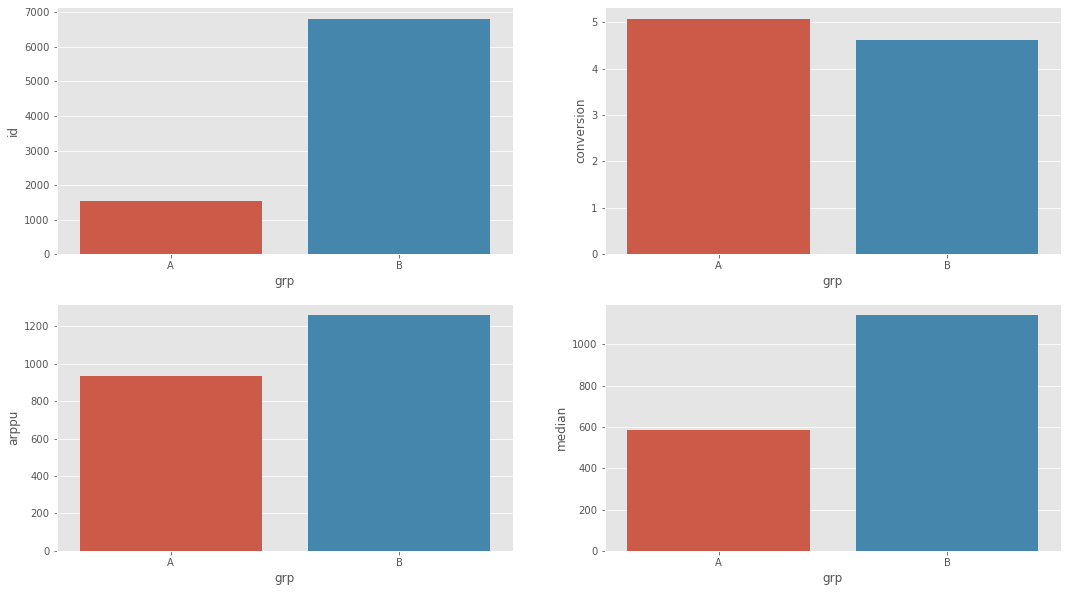

In [ ]:
plot_metrics(user_groups, conversion, arppu, median)

**The function works**